# Using STDP to classify the MNIST dataset

In [1]:
%load_ext autoreload
%autoreload 2
# basic libraries
import os
import sys
import time
import numpy as np
import pandas as pd

# graphics libraries
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
import jupyterlab_widgets as lab
from IPython.display import display
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
%config InlineBackend.figure_format='retina'
# use NMA plot style
#plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
plt.style.use('seaborn-v0_8')
my_layout = widgets.Layout()
my_layout.width = '620px'

#machine Learning libraries
import torch
import torch.nn as nn
import snntorch as snn
import snntorch.spikeplot as splt
from snntorch import utils
from snntorch import spikegen

# hyperparameters optimization
import optuna
from optuna.visualization import *
import pickle

#import from my scripts
main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)
import importlib

importlib.reload(importlib.import_module('snn_experiments'))
importlib.reload(importlib.import_module('snn_plot_utils'))
importlib.reload(importlib.import_module('snn_models'))
importlib.reload(importlib.import_module('snn_datasets'))

from snn_experiments import *
from snn_plot_utils import *
from snn_models import *
from snn_datasets import *


# show packages versions for python, numpy, and ipywidgets
print("Python: ", sys.version)
print("Numpy: ", np.__version__)
print("Pandas: ", pd.__version__)
print("jupyterlab_widgets: ", lab.__version__ )
print("IPywidgets: ", widgets.__version__)
print("Torch: ", torch.__version__)
print("Snntorch: ", snn.__version__) # version 0.6.4 before update, current version online 0.7.0
print("Optuna: ", optuna.__version__)

Python:  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Numpy:  1.26.0
Pandas:  2.1.1
jupyterlab_widgets:  3.0.9
IPywidgets:  8.0.4
Torch:  2.1.0
Snntorch:  0.6.4
Optuna:  3.5.0


# 1. Intro with artificial correlated data


## 1.1 Spotting correlated input with synaptic lif and external STDP class

Simulation time: 66.04 seconds


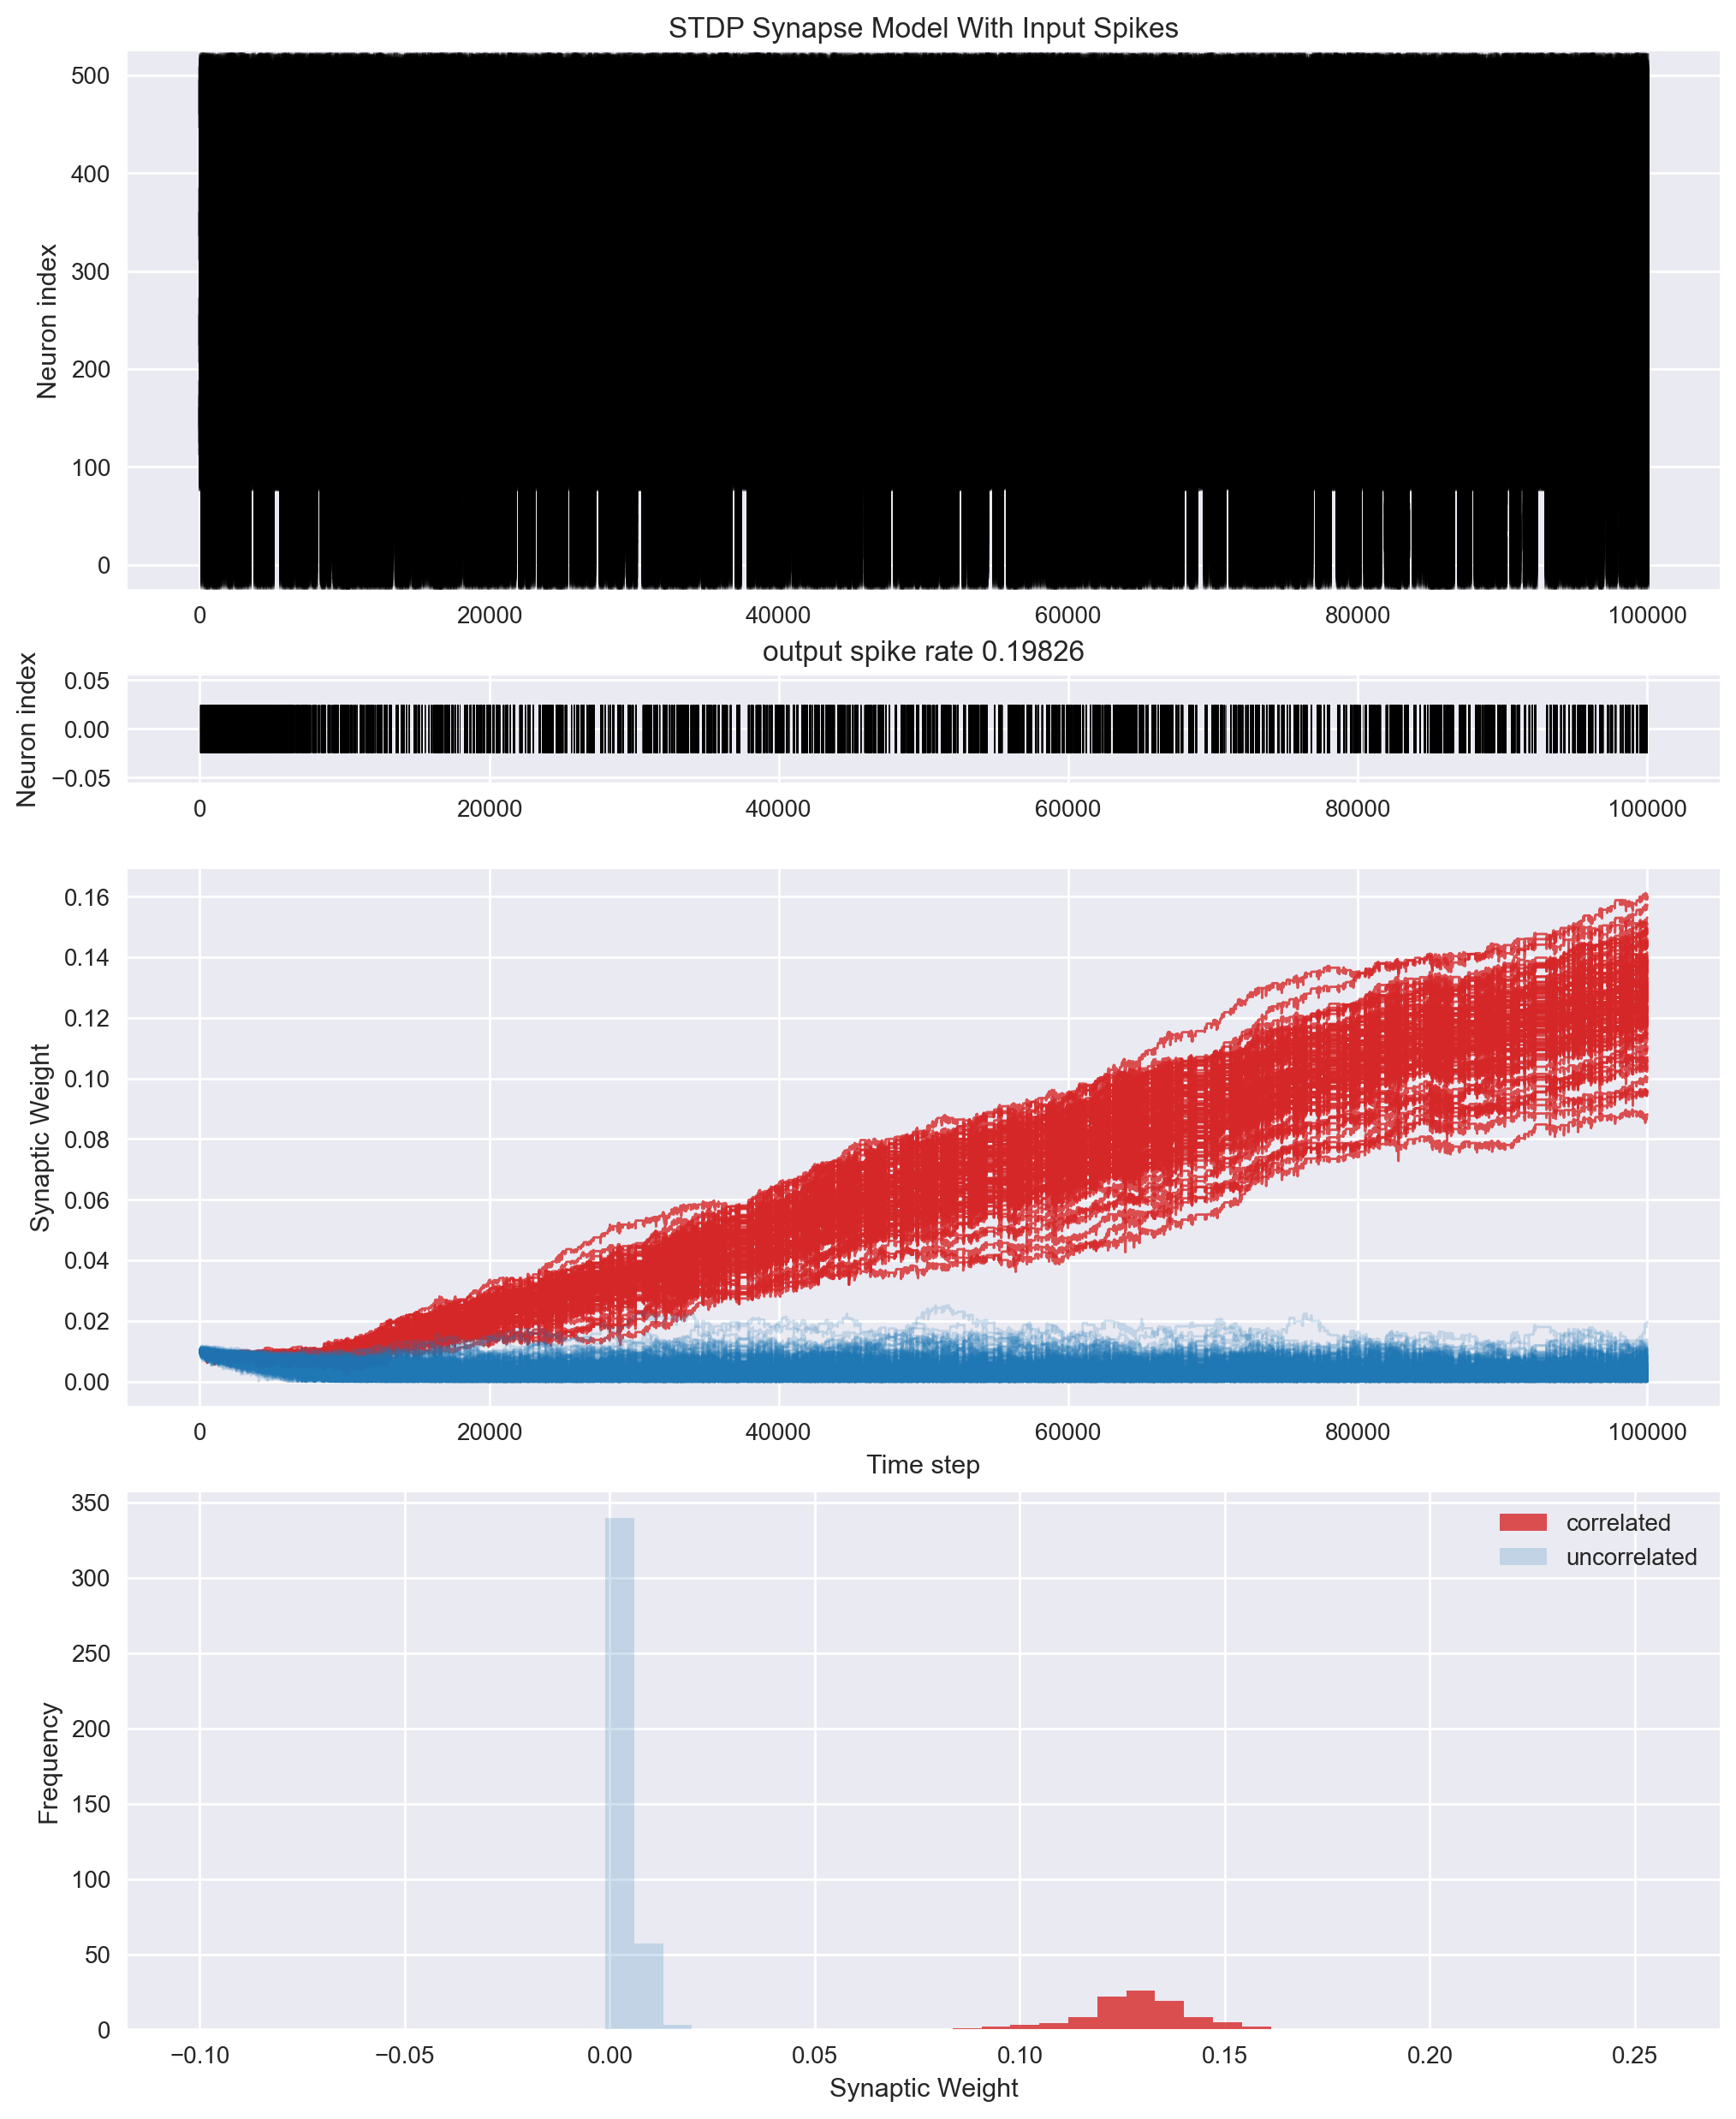

In [2]:
# basic variables
N_pre = 500
N_pre_correlated = 100
N_post = 1
num_steps = 100000

# parameters of the simulation
pars = default_pars(type_parameters='simple', 
                    w_init_value = 0.1,
                    A_minus = 0.0088 * 0.024,
                    A_plus = 0.008 * 0.024,)
dt = pars['dt']
time_steps = np.arange(num_steps) * dt
rate = 0.01

# generate the injected spikes with some correlation
cur_in_numpy,_ = random_shifted_trains(dt, num_steps, N_pre, N_pre_correlated , rate = rate, shift_values=[-20,20]) 
cur_in = torch.from_numpy(cur_in_numpy)

# initialize the weights
W = np.random.rand(N_post, N_pre) * pars['w_init_value'] / 100
W = weight_initializer(pars, N_post, I=cur_in_numpy, type_init=2) * pars['w_init_value']  #* np.random.rand(N_post,N_pre) # noise added to appreciate different STDP dynamics
W = torch.from_numpy(W)

# initialize postsynaptic neurons
beta = np.exp(-pars['dt']/pars['tau_m'] *(1+pars['max_g'])) # or 0.8
alpha = np.exp(-pars['dt']/pars['tau_syn_exc']) #or 0.9
rm = 'zero' if pars['hard_reset'] else 'subtract' 
thr = pars['threshold']
post_neurons = [ snn.Synaptic(alpha = alpha, beta = beta, threshold=thr, reset_mechanism=rm) for _ in range(N_post)]

# initialize the tracking variables
mem_record = np.zeros((num_steps+1, N_post))
spk_record = np.zeros((num_steps+1, N_post))
cond_record = np.zeros((num_steps+1, N_post))
mem_record[0,:] = np.asarray([0 for i in range(N_post)])
spk_record[0,:] = np.asarray([0 for i in range(N_post)])
cond_record[0,:] = np.asarray([0 for i in range(N_post)])

# intialize the synapses
my_synapses = STDP_synapse(pars, N_pre, N_post, W_init = W ) # this works even if now W is a tensor!

# run the simulation
start_time = time.time()
for step in range(num_steps):
    # current injected at this time step
    pre_syn_spikes = cur_in[step]
    cur_in_step = W @ pre_syn_spikes

    #spike generated by the layer
    for i in range(N_post):
        spk, cond, mem = post_neurons[i](cur_in_step[i], cond_record[step, i], mem_record[step,i])
        spk_record[step+1,i] = spk
        mem_record[step+1,i] = mem
        cond_record[step+1,i] = cond

    post_syn_spk = spk_record[step+1,:]
    
    # update the weights
    my_synapses.update_weights([pre_syn_spikes.detach().numpy(),post_syn_spk])
    W = my_synapses.W

print(f"Simulation time: {time.time() - start_time:.2f} seconds")

# convert the results to torch tensors
mem_record = torch.from_numpy(mem_record[1:,:])
spk_record = torch.from_numpy(spk_record[1:,:])

weight_history = my_synapses.get_records()['W'][1:,0,:]
plot_raster_weight_distr(cur_in, spk_record, weight_history, N_pre_correlated)



## 1.2 Spotting correlated input with an SNN with 1 FC layer, Synaptic Neuron, classic STDP

Forward pass time : --- 85.97 seconds ---


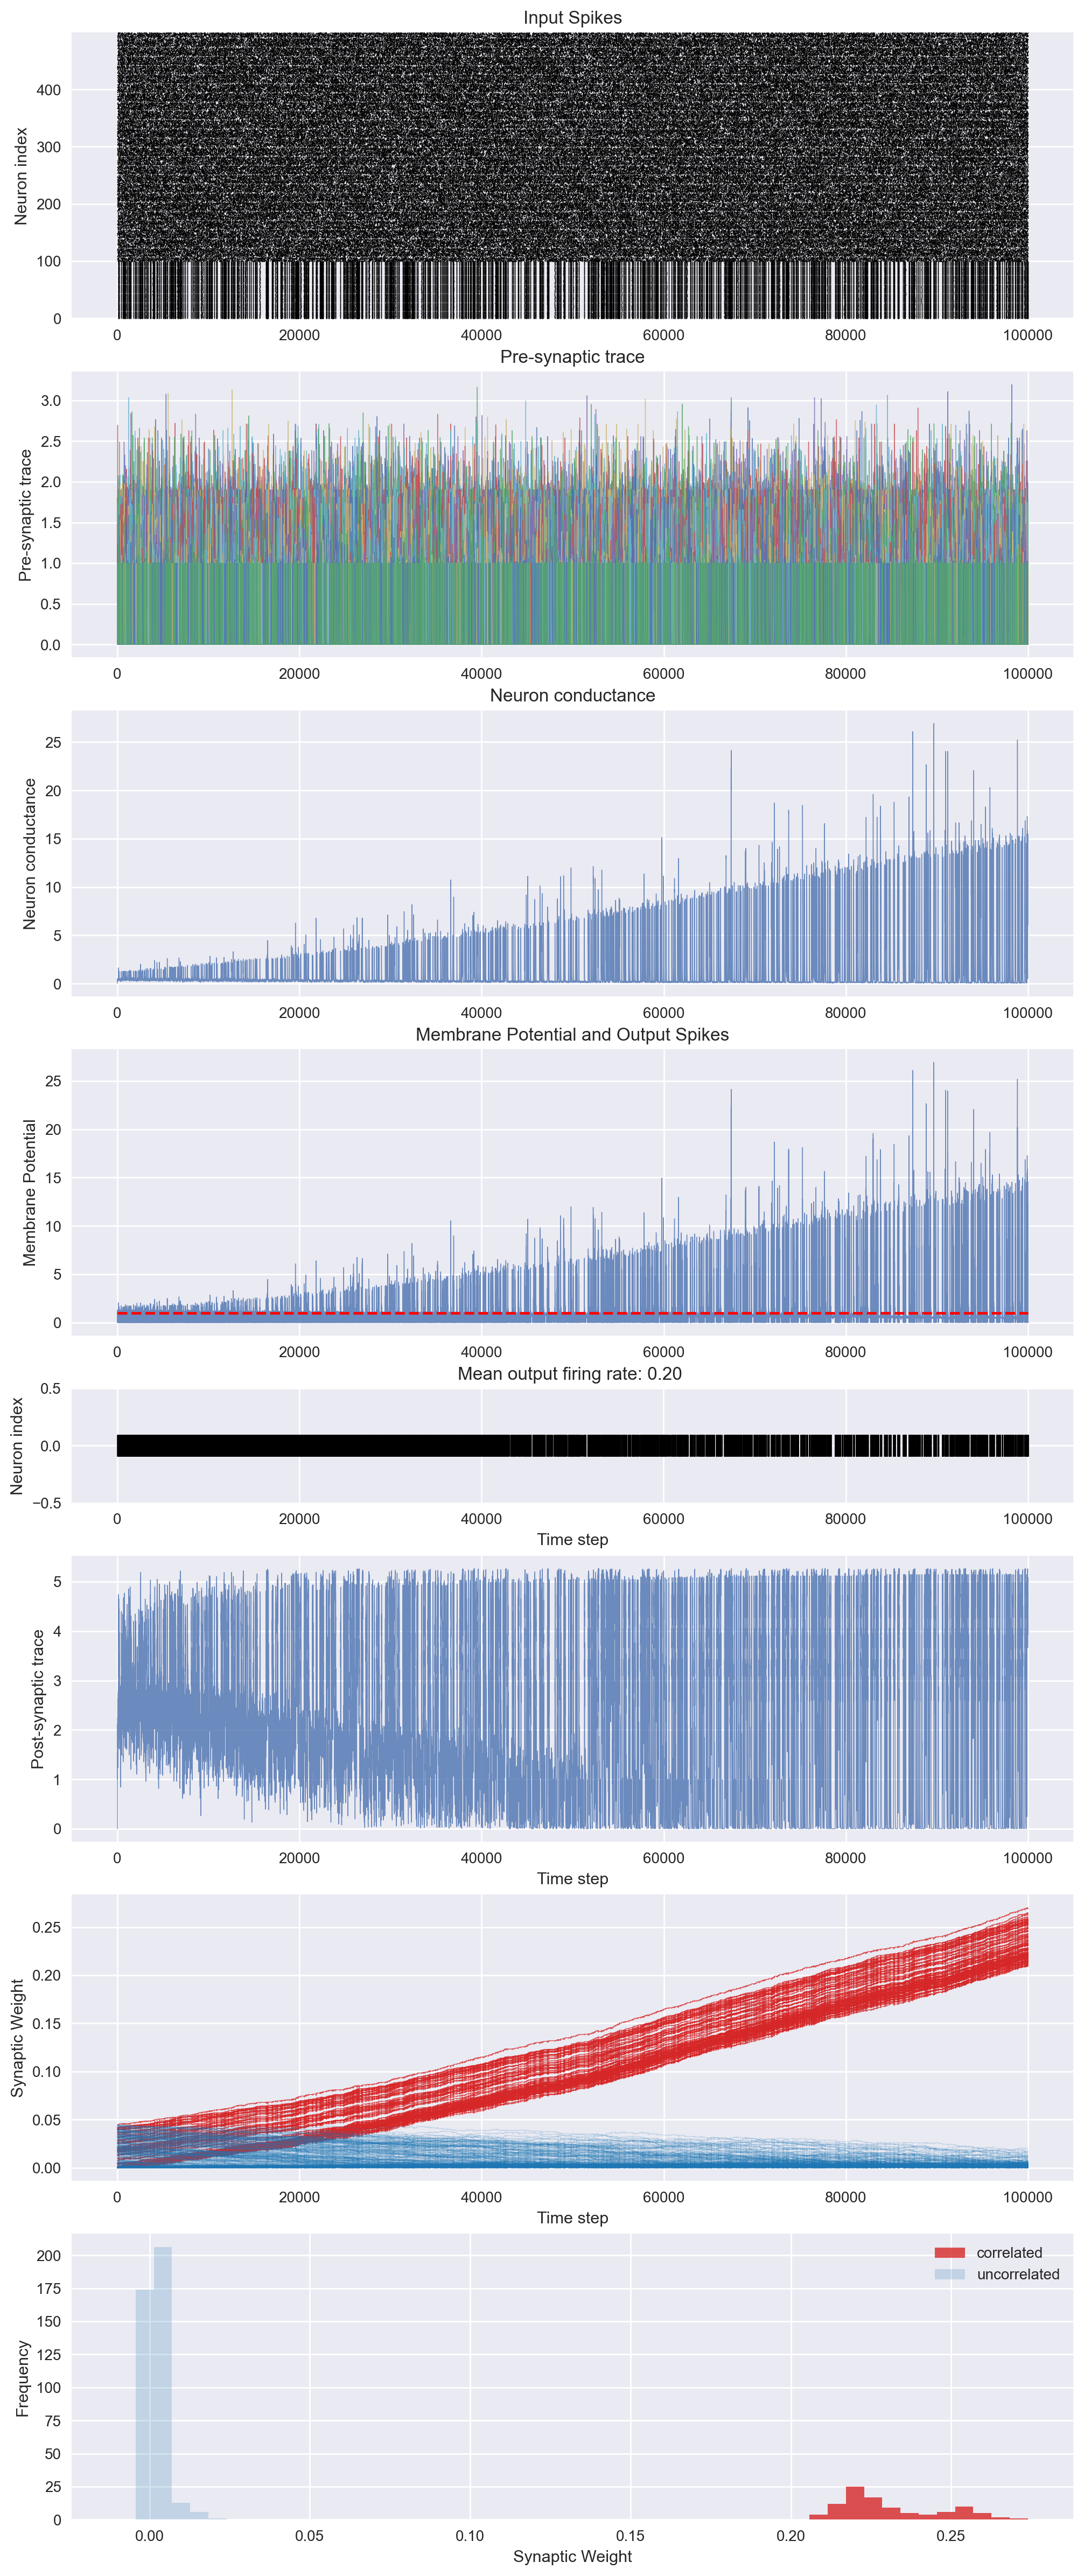

In [3]:
# basic variables
# basic variables
N_pre = 500
N_pre_correlated = 100
N_post = 1
num_steps = 100000
batch_size = 0 # for the moment we do not use batch size
rate = 0.01

class synaptic_stdp(nn.Module):

    def __init__(self, pars, N_pre, N_post = 1):
        super(synaptic_stdp, self).__init__()
        self.pars = pars
        self.alpha = pars.get('alpha', 0.9)
        self.beta = pars.get('beta', 0.8)
        self.w_max = pars.get('w_max', 1.0)
        self.w_min = pars.get('w_min', 0.0)
        self.fc = nn.Linear(N_pre, N_post, bias=False)
        # clamp the weight to positive values
        self.fc.weight.data = torch.clamp(self.fc.weight.data, min=self.w_min, max=self.w_max)
        # set the weight of the layer
        #W_init = weight_initializer(pars, N_pre, N_post, type_init = 3, tensor = True)
        #self.fc.weight = nn.Parameter(W_init)
        reset_mechanism = 'zero' if pars['hard_reset'] else 'subtract'
        self.lif = snn.Synaptic(alpha = self.alpha, beta = self.beta, threshold = pars['threshold'], reset_mechanism = reset_mechanism)

    def forward(self, x):
        # initiliaze the membrane potential and the spike
        cond, mem = self.lif.init_synaptic()

        #tracking variables
        mem_rec = []
        spk_rec = []
        cond_rec = []
        # dovrei inizializzare tutto o come liste o come tensori...
        pre_syn_traces = generate_traces(self.pars, x)
        post_syn_traces = torch.zeros((x.shape[0]+1, N_post))
        weight_history = torch.zeros((x.shape[0]+1, N_post, N_pre))
        weight_history[0,:,:] = self.fc.weight.data

        for step in range(x.shape[0]):
            # run the fc layer
            cur_step = self.fc(x[step])
            # run thw lif neuron
            spk, cond,  mem = self.lif(cur_step, cond, mem)

            # store the membrane potential and the spike
            mem_rec.append(mem)
            spk_rec.append(spk)
            cond_rec.append(cond)

            # updatae post synaptic traces
            beta_minus = self.pars.get('beta_minus',0.9)
            post_syn_traces[step+1, :] = beta_minus*post_syn_traces[step, :] + spk

            # update the weights
            weight_history[step,:,:] = self.fc.weight.data
            A_plus, A_minus = self.pars['A_plus'], self.pars['A_minus']
            LTP = A_plus * torch.outer(spk, pre_syn_traces[step,:]) 
            LTD = A_minus * torch.outer(post_syn_traces[step+1,:], x[step])
            self.fc.weight.data = self.fc.weight.data + LTP - LTD
            # hard constrain on the weights
            self.fc.weight.data = torch.clamp(self.fc.weight.data, min=self.w_min, max=self.w_max)


        post_syn_traces = post_syn_traces[:-1,:]
        weight_history = weight_history[:-1,:,:]

        self.records = {'mem': torch.stack(mem_rec), 
                        'spk': torch.stack(spk_rec), 
                        'cond':  torch.stack(cond_rec), 
                        'pre_trace': pre_syn_traces, 
                        'post_trace': post_syn_traces, 
                        'W': weight_history}

        return 
    
    



# parameters of the simulation
pars = default_pars(type_parameters='simple', 
                    w_init_value = 0.012,
                    alpha = 0.9,
                    beta = 0.8,
                    threshold = 1.0,
                    hard_reset = True,
                    A_minus = 0.0088 * 0.024,
                    A_plus = 0.008 * 0.024,
                    beta_minus = 0.9,
                    beta_plus = 0.9)
dt = pars['dt']

# generate the input spikes
cur_in_numpy,_ = random_shifted_trains(dt, num_steps, N_pre, N_pre_correlated , rate = rate, shift_values=[-5,5]) 
cur_in = torch.from_numpy(cur_in_numpy)
cur_in = cur_in.to(dtype = torch.float32, device = device)

# intitilize the model
my_model = synaptic_stdp(pars, N_pre, N_post)

# run the simulation
#my_model.train()
start_time = time.time()
my_model.forward(cur_in)
print(f"Forward pass time : --- {(time.time() - start_time):.2f} seconds ---")
mem_rec, spk_rec, cond_rec, pre_trace, post_trace, weight_history = my_model.records['mem'], my_model.records['spk'], my_model.records['cond'], my_model.records['pre_trace'], my_model.records['post_trace'], my_model.records['W']

# plot results
plot_results_32(dt, cur_in, pre_trace.detach().numpy(), 
                cond_rec.detach().numpy(), 
                mem_rec.detach().numpy(), 
                spk_rec, 
                post_trace.detach().numpy(), 
                weight_history.detach().numpy(), N_pre, N_pre_correlated, N_post, num_steps)


## 1.3 Spotting correlated input with the general SNN that we will use also for the MNIST

Forward pass time : --- 58.62 seconds ---


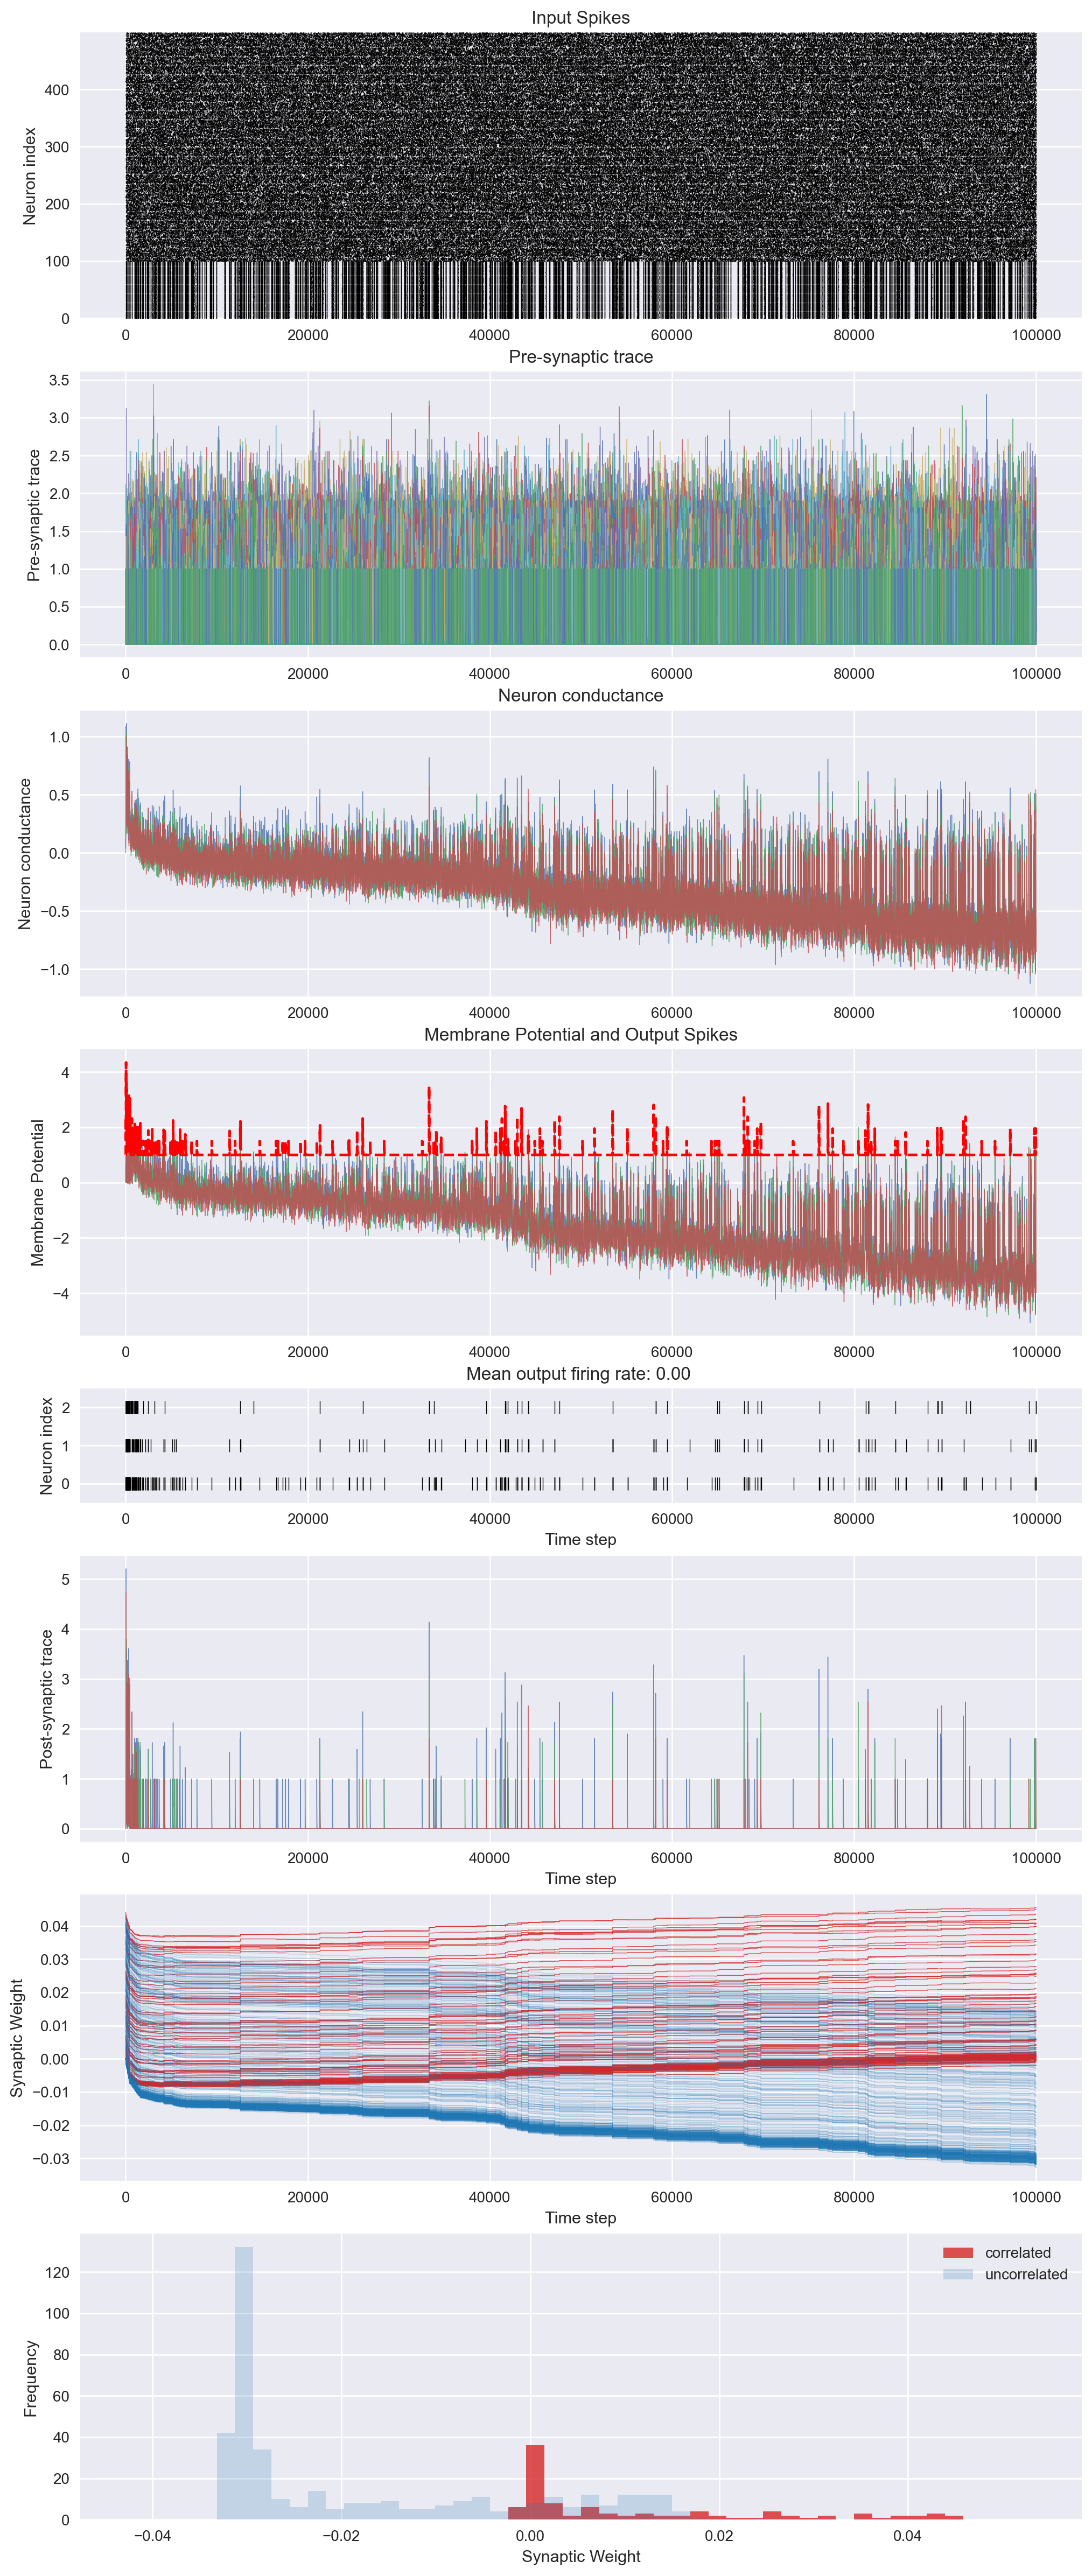

In [4]:
num_steps = 100000
N_pre = 500
N_pre_correlated = 100
rate = 0.01
dt = 1
N_post = 3

pars = mnist_pars(
    STDP_type = 'offset',
    STDP_offset = 0.7,
    num_steps = num_steps,
    A_minus = 0.0088*0.024, 
    A_plus = 0.008*0.024,
    reset_mechanism = 'subtract',
    dynamic_threshold = True,
    tau_theta = 20, 
    theta_add = 0.5,
    refractory_period = False,
    ref_time = 2,
    lateral_inhibition = False,
    lateral_inhibition_strength = 0.1,
    store_subsampling_factor=1
)

# create the input spike trains
cur_in_numpy_base,_ = random_shifted_trains(dt, num_steps, N_pre, N_pre_correlated , rate = rate, shift_values=[-5,5]) 
# add a batch dimension to cur_in_numpy
cur_in_numpy = cur_in_numpy_base[:,None,:]
cur_in = torch.from_numpy(cur_in_numpy)
cur_in_base = torch.from_numpy(cur_in_numpy_base)
cur_in = cur_in.to(dtype = torch.float32, device = device)

model = snn_mnist(pars, N_pre, N_post)
model.eval()

start_time = time.time()
model.forward(cur_in)
print(f"Forward pass time : --- {(time.time() - start_time):.2f} seconds ---")

pre_trace = model.get_records()['pre_trace']
cond_rec = model.get_records()['syn']
mem_rec = model.get_records()['mem']
threshold_rec = model.get_records()['threshold']
spk_rec = model.get_records()['spk']
post_trace = model.get_records()['post_trace']
weight_history = model.get_records()['W']

plot_results_32(dt, cur_in_base, pre_trace, cond_rec, mem_rec, spk_rec, post_trace, weight_history, N_pre, N_pre_correlated, N_post, num_steps, threshold_rec = threshold_rec)

# 2. Digit recognition

## 2.1 MNIST encoding in spike trains

FULL DATASETS LOADER
Size of a batch of spike data is torch.Size([350, 50, 784])
Length of the train_loader is 1000
Size of a batch of spike data is torch.Size([350, 50, 784])
Length of the val_loader is 200
Size of a batch of spike data is torch.Size([350, 50, 784])
Length of the test_loader is 200

SUBSET DATASETS LOADER
Size of a batch of spike data is torch.Size([350, 50, 784])
Length of the sub_train is 16
Size of a batch of spike data is torch.Size([350, 50, 784])
Length of the sub_val is 4
Size of a batch of spike data is torch.Size([350, 50, 784])
Length of the sub_test is 4


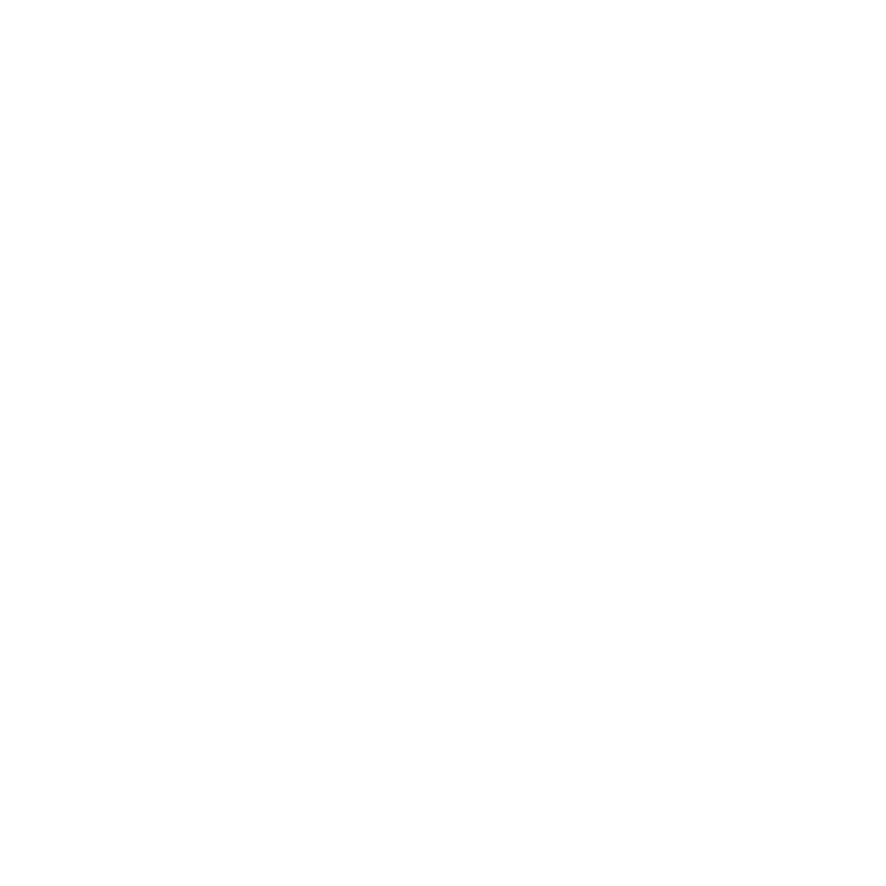

In [11]:
# parameters of the simulation       
batch_size = 50
num_steps = 350
gain = 1.
min_rate = 0.

# Create the datasets
mnist_train = rate_encoded_mnist(batch_size, num_steps=num_steps, gain=gain, min_rate = min_rate, train=True, my_seed = 42)
mnist_test = rate_encoded_mnist(batch_size, num_steps=num_steps, gain=gain, min_rate = min_rate, train=False, my_seed = 42)

# Get the dataloaders
train_loader, val_loader = mnist_train.get_loader()
test_loader = mnist_test.get_loader()

# get the subset loader
subset_loader = mnist_train.get_subset(subset=100) # this was used in a first phase
sub_train, sub_val, sub_test = mnist_train.get_subset_train_val_test(subset = 50)

# check the shape in the loaders and the loader length
print("FULL DATASETS LOADER")
data = iter(train_loader)
data_it, targets_it = next(data)
print(f"Size of a batch of spike data is {data_it.size()}")
print(f"Length of the train_loader is {len(train_loader)}")

data = iter(val_loader)
data_it, targets_it = next(data)
print(f"Size of a batch of spike data is {data_it.size()}")
print(f"Length of the val_loader is {len(val_loader)}")

data = iter(test_loader)
data_it, targets_it = next(data)
print(f"Size of a batch of spike data is {data_it.size()}")
print(f"Length of the test_loader is {len(test_loader)}")
print("")
# check the shape in the subset loaders and the loaders length
print("SUBSET DATASETS LOADER")
data_sub_train = iter(sub_train)
data_it, targets_it = next(data_sub_train)
print(f"Size of a batch of spike data is {data_it.size()}")
print(f"Length of the sub_train is {len(sub_train)}")

data_sub_val = iter(sub_val)
data_it, targets_it = next(data_sub_val)
print(f"Size of a batch of spike data is {data_it.size()}")
print(f"Length of the sub_val is {len(sub_val)}")

data_sub_test = iter(sub_test)
data_it, targets_it = next(data_sub_test)
print(f"Size of a batch of spike data is {data_it.size()}")
print(f"Length of the sub_test is {len(sub_test)}")

# save the animation of a spike image
save_animations = False
if not save_animations:
    data = iter(subset_loader)
    data_it, targets_it = next(data)
    spike_data = data_it[:,0,:].view(-1,28,28)  # selectthe first element of the batch
    target = targets_it[0]  
    fig, ax = plt.subplots()
    anim = splt.animator(spike_data, fig, ax)
    #If you're feeling sentimental, you can save the animation: .gif, .mp4 etc.
    anim.save(f"animations/num_steps_{num_steps}-gain_{gain}-min_rate_{min_rate}.mp4")

## 2.2 Some preliminaries 

### Class assignment function


In [25]:
num_epochs = 2
num_steps = 100
min_spk_number = 1
pars = mnist_pars(
    STDP_type = 'classic',
    num_steps = num_steps,
    A_minus = 0.0088 ,
    A_plus = 0.008 ,
    reset_mechanism = 'subtract',
    dynamic_threshold = False,
    tau_theta = 5, 
    theta_add = 0.1,
    refractory_period = False,
    ref_time = 2,
    lateral_inhibition = False,
    lateral_inhibition_strength = 1,
    gain = 0.1,
)
N_pre = 28*28
N_post = 20
model = snn_mnist(pars, N_pre, N_post)

assignments, df = assign_neurons_to_classes(model, val_loader = subset_loader)

print(assignments)
display(df)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]


0          1          2          3          4  \
0              0.999409   0.996817   0.998482   0.998547   0.997530   
1              0.999606   0.996673   0.998661   0.998305   0.997724   
2              0.999409   0.996709   0.999018   0.998499   0.997772   
3              0.999655   0.996600   0.999152   0.998886   0.997724   
4              0.999163   0.996854   0.998795   0.998257   0.997627   
5              0.998916   0.995696   0.998259   0.997627   0.997191   
6              0.999409   0.996347   0.998795   0.998450   0.997772   
7              0.999507   0.996130   0.998705   0.998789   0.997482   
8              0.999606   0.995986   0.998661   0.998644   0.997482   
9              0.999803   0.996492   0.998929   0.998741   0.997676   
10             0.999261   0.995805   0.998705   0.997579   0.997627   
11             0.999557   0.995262   0.998616   0.998305   0.997288   
12             0.999458   0.996817   0.998884   0.998644   0.997724   
13             0.999360   0.996311   0.998527   0.998160   0.997433   
14             0.999212   0.996890   0.999241   0.998596   0.997869   
15             0.999458   0.996745   0.998839   0.998354   0.997385   
16             0.999606   0.996094   0.998839   0.998402   0.997337   
17             0.999507   0.996456   0.998705   0.998692   0.997385   
18             0.999458   0.996239   0.998616   0.998741   0.997385   
19             0.999557   0.996058   0.998795   0.997966   0.997433   
sample_count  58.000000  79.000000  64.000000  59.000000  59.000000   

                      5          6          7          8          9  max_index  
0              0.997423   0.997989   0.997465   0.998601   0.997231          0  
1              0.997815   0.998307   0.997558   0.998134   0.997319          0  
2              0.997871   0.998519   0.997788   0.998892   0.997582          0  
3              0.998039   0.998519   0.997281   0.998834   0.997319          0  
4              0.997759   0.997989   0.997281   0.998892   0.997231          0  
5              0.997199   0.997619   0.997281   0.997493   0.997099          0  
6              0.997703   0.997937   0.997373   0.998309   0.997582          0  
7              0.997927   0.998095   0.997465   0.998426   0.997451          0  
8              0.997871   0.997566   0.997235   0.998367   0.997231          0  
9              0.998039   0.998360   0.997512   0.998542   0.997319          0  
10             0.997199   0.997725   0.997051   0.997493   0.996967          0  
11             0.997703   0.998201   0.997005   0.997901   0.996967          0  
12             0.997815   0.998624   0.997235   0.998542   0.997407          0  
13             0.997703   0.998148   0.997005   0.997843   0.997231          0  
14             0.997703   0.998307   0.997696   0.998950   0.997451          2  
15             0.997535   0.998307   0.997235   0.998017   0.997187          0  
16             0.997647   0.998571   0.997788   0.998251   0.997231          0  
17             0.997647   0.997937   0.997696   0.997843   0.997275          0  
18             0.997815   0.998042   0.997373   0.998251   0.997231          0  
19             0.997255   0.998201   0.997051   0.997668   0.997363          0  
sample_count  51.000000  54.000000  62.000000  49.000000  65.000000          1

### Evaluation Function

In [7]:
# modify the assignments to have random classes
for i in range(N_post):
    assignments[i] = np.random.randint(0, 9)

# classify the data in the subset loader
test_accuracy = classify_test_set(model, subset_loader, assignments)

display(test_accuracy)

0.11166666666666666

### Training function

100%|████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.15batch/s, acc=0.0383, time=5.08s]


 The total training time is 9.83 seconds
The size of records is 0.27 KB


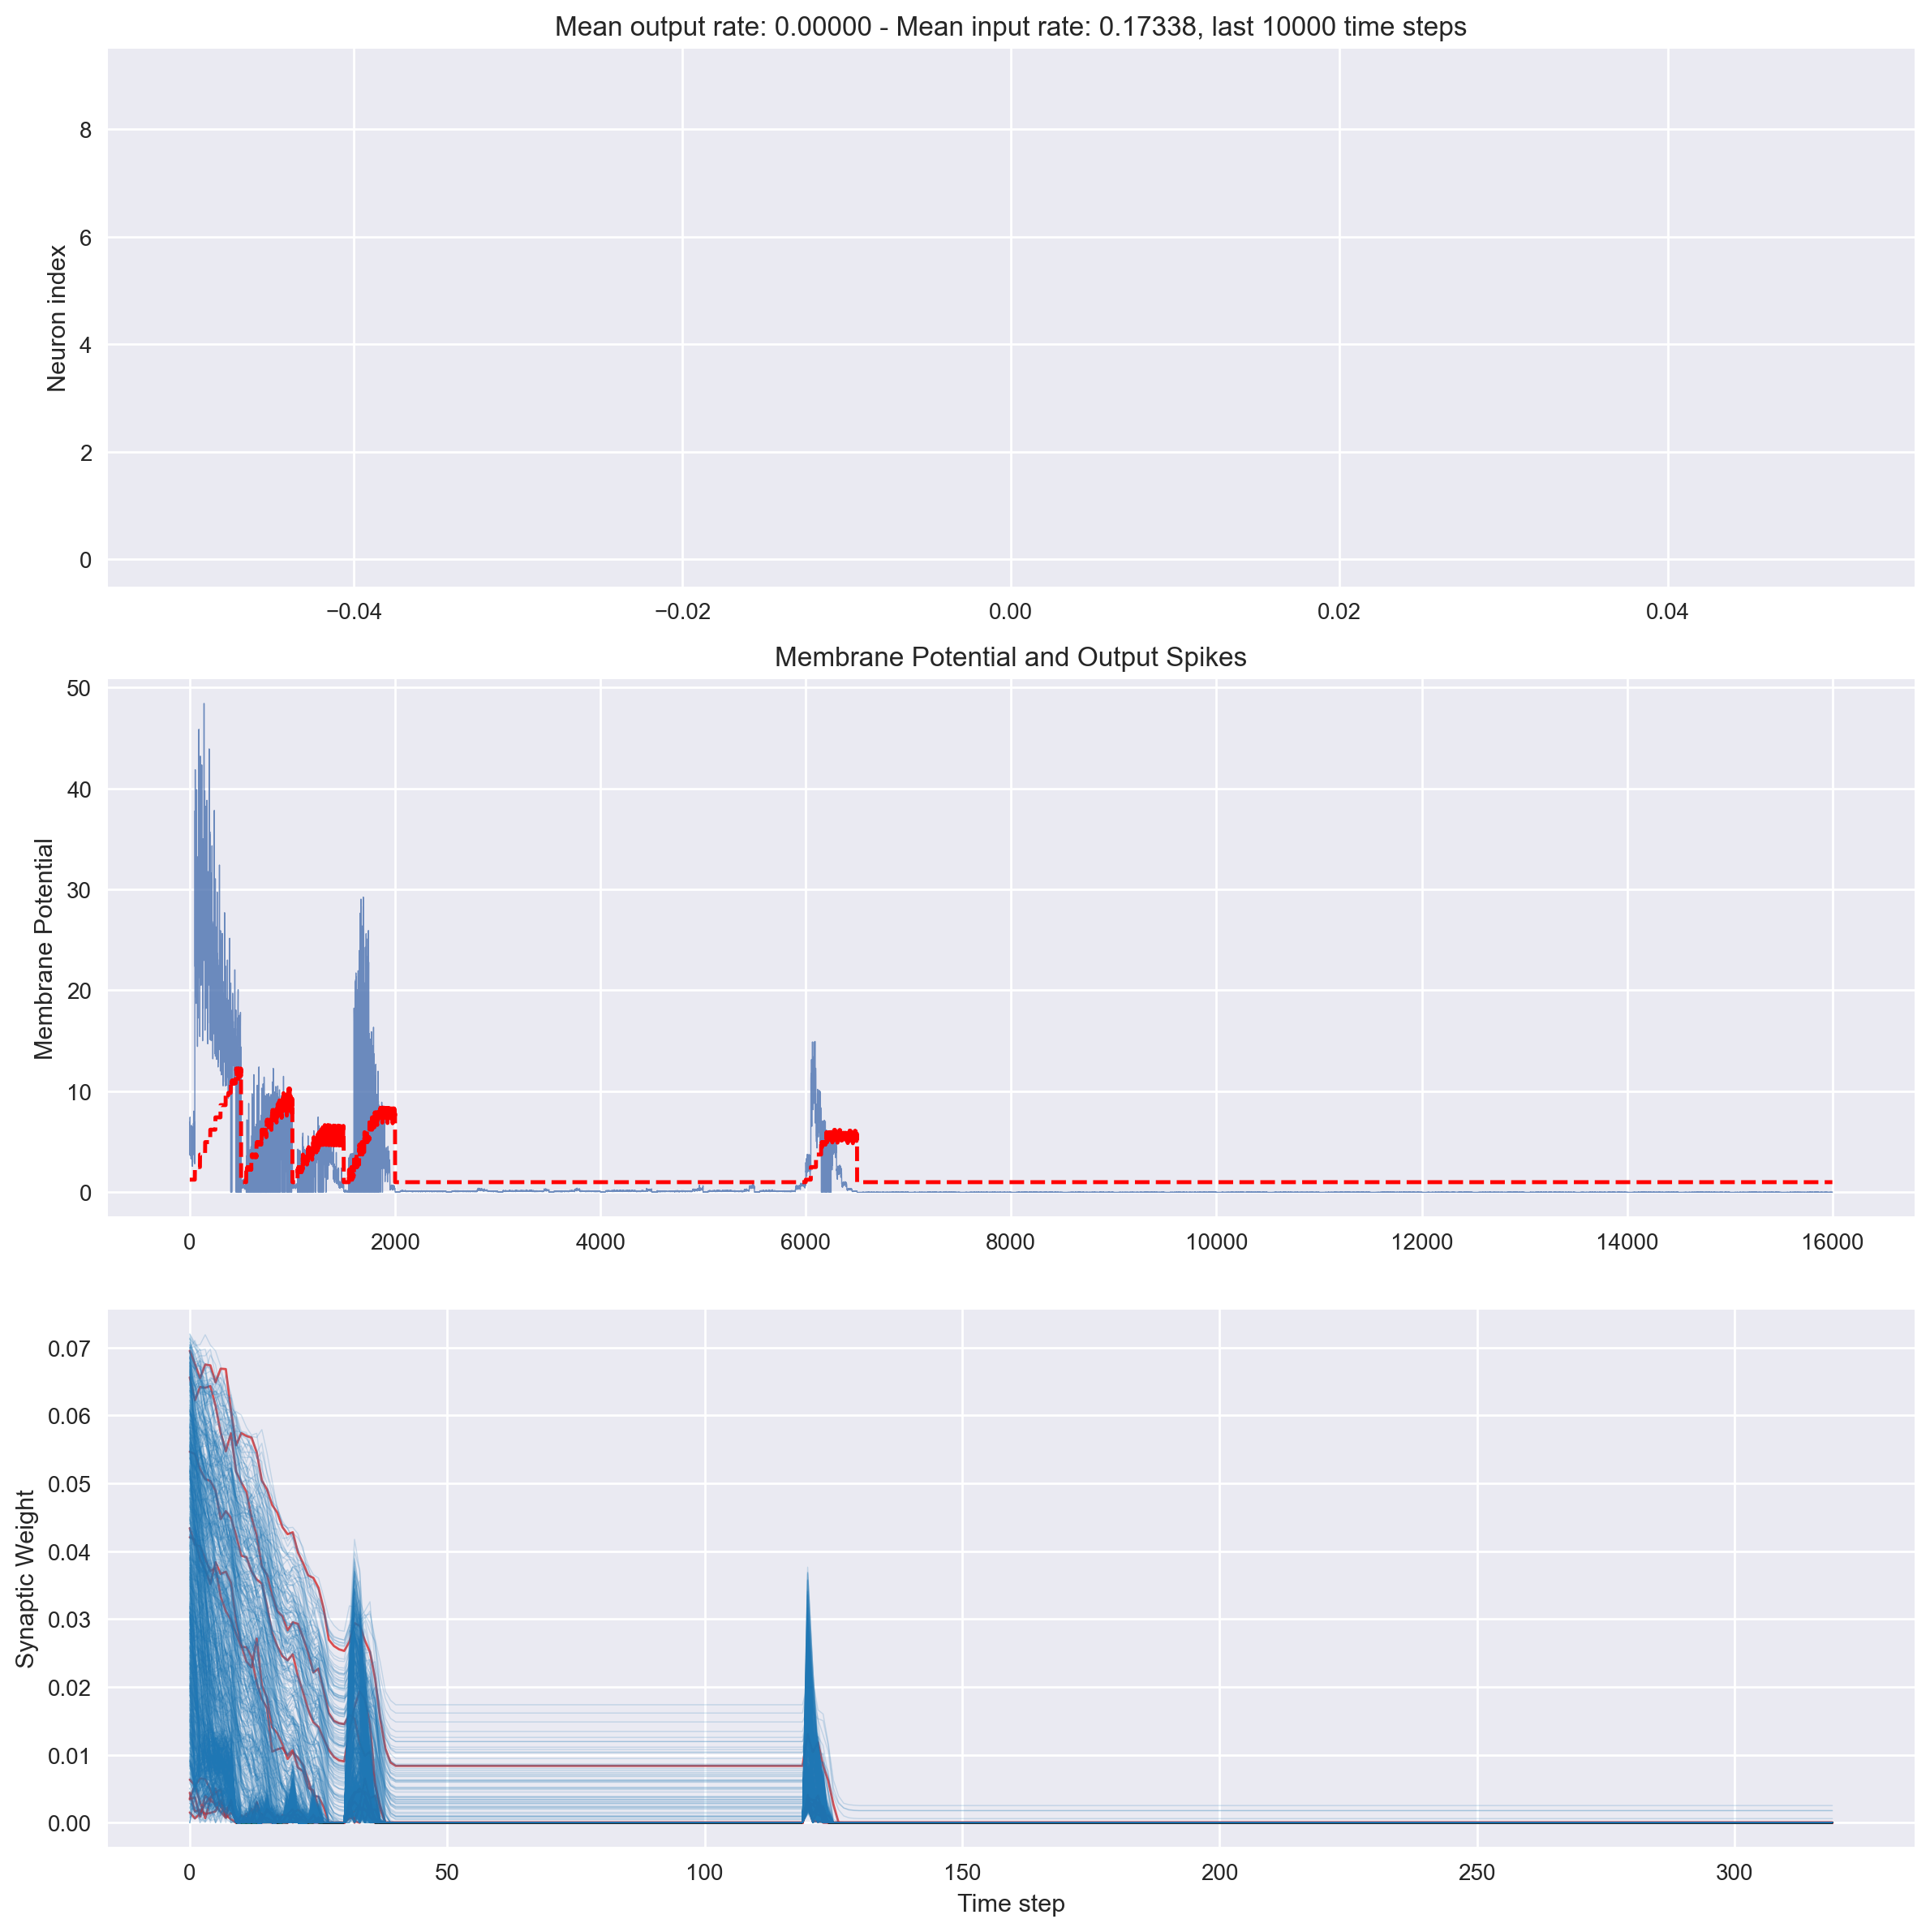

 The total plotting time is 4.11 seconds


In [39]:
num_epochs = 2
min_spk_number = 1
num_steps = 100
pars = mnist_pars(
    STDP_type = 'classic',
    num_steps = num_steps,
    A_minus = 0.00011,
    A_plus = 0.0001 ,
    reset_mechanism = 'zero',
    dynamic_threshold = True,
    tau_theta = 2000, 
    theta_add = 0.25,
    refractory_period = False,
    ref_time = 2,
    lateral_inhibition = True,
    lateral_inhibition_strength = 0.1,
    gain = 0.1,
    use_min_spk_number = False,
    min_spk_number = min_spk_number,
    weight_initialization_type = 'shift'
)

N_pre = 28*28
N_post = 10
model = snn_mnist(pars, N_pre, N_post)

# Train the model
start_time = time.time()
model = train_model(model, 
                    train_loader = sub_train, 
                    val_loader = sub_val,
                    num_epochs = num_epochs, 
                    )
print(f' The total training time is {time.time() - start_time:.2f} seconds')

# print the ram size of records_full
print(f"The size of records is {sys.getsizeof(model.get_records())/1e3:.2f} KB")

# plot the results
start_time = time.time()
model.plot_simulation()
print(f' The total plotting time is {time.time() - start_time:.2f} seconds')

In [9]:
print(f'the forward count is {model.forward_count}')
print(f'the batch size is {model.batch_size}')
print(f'the num steps is {model.num_steps}')
print(f'The total simulation time is {model.tot_sim_time:.2f} seconds')
print(f'subsampling rate of records is {model.t}')

# check that the records have all the correct shapes
records = model.get_records()
for key in records.keys():
    print(f'{key} has shape {records[key].shape}')

the forward count is 24
the batch size is 50
the num steps is 100
The total simulation time is 120000.00 seconds
subsampling rate of records is 10
mem has shape (12000, 10)
spk has shape torch.Size([120000, 10])
syn has shape (12000, 10)
threshold has shape (12000, 10)
pre_trace has shape (12000, 784)
post_trace has shape (12000, 10)
W has shape (240, 10, 784)


## 2.3 Hyperparameters Tuning

### Phase 1: time constants and learning rates for both STDP types


In [40]:
# Add stream handler of stdout to show the messages
#optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout)) # run this linenot in notebook.

# name and storage for the study
study_name = 'STDP_optimization_1'
study_storage = f'sqlite:///{main_dir}/{study_name}.db'

# instantiate the optization study
study = optuna.create_study(
    direction="maximize", 
    study_name = study_name,
    storage = study_storage,
    load_if_exists = True,
    sampler = optuna.samplers.TPESampler(seed=42),
    pruner = optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=0, interval_steps=1,  n_min_trials=1)
)
study.set_user_attr("dataset", "MNIST")
print(f"Sampler is {study.sampler.__class__.__name__}")
print(f"Pruner is {study.pruner.__class__.__name__}")

# save the sampler with pickle
with open("sampler_1.pkl", "wb") as fout:
    pickle.dump(study.sampler, fout)



[I 2024-03-08 16:57:07,233] A new study created in RDB with name: STDP_optimization_1


Sampler is TPESampler
Pruner is MedianPruner


In [41]:
#optimize for a few trials
study.optimize(
    objective, 
    n_trials = 2, 
    timeout = 100,
    n_jobs=1, 
    catch=(), 
    callbacks=None, 
    gc_after_trial=True, 
    show_progress_bar=False)


pruned_traials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print(f"Study statistics: ")
print(f"  Number of finished trials: {len(study.trials)}")
print(f"  Number of pruned trials: {len(pruned_traials)}")
print(f"  Number of complete trials: {len(complete_trials)}")

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

100%|████████████████████████████████████████████████████████| 26/26 [00:07<00:00,  3.25batch/s, acc=0.0003, time=7.97s]
[I 2024-03-08 16:57:36,751] Trial 0 finished with value: 0.00025 and parameters: {'STDP_type': 'offset', 'STDP_offset': 0.015702970884055395, 'learning_rate': 0.006251373574521752, 'beta_minus': 0.24041677639819287, 'reset_mechanism': 'subtract', 'alpha': 0.8795585311974417, 'beta': 0.6410035105688879, 'inhi_strength': 1.3311216080736887, 'n_neurons': 16, 'batch_size': 30, 'num_steps': 100}. Best is trial 0 with value: 0.00025.
100%|██████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.22s/batch, acc=0.0003, time=4.82s]
[I 2024-03-08 16:57:50,597] Trial 1 finished with value: 0.0002666666666666667 and parameters: {'STDP_type': 'offset', 'STDP_offset': 0.0019762189340280074, 'learning_rate': 0.0007476312062252305, 'beta_minus': 0.6506676052501416, 'reset_mechanism': 'zero', 'alpha': 0.4297256589643226, 'beta': 0.5104629857953323, 'inhi_stren

Study statistics: 
  Number of finished trials: 2
  Number of pruned trials: 0
  Number of complete trials: 2
Best trial:
  Value: 0.0002666666666666667
  Params: 
    STDP_type: offset
    STDP_offset: 0.0019762189340280074
    learning_rate: 0.0007476312062252305
    beta_minus: 0.6506676052501416
    reset_mechanism: zero
    alpha: 0.4297256589643226
    beta: 0.5104629857953323
    inhi_strength: 2.267398652378039
    n_neurons: 64
    batch_size: 200
    num_steps: 100


In [15]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [18]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [ ]:
optuna.importance.get_param_importances(
    study, 
    evaluator=None, 
    params=['A_minus','A_plus', 'beta_plus','beta_minus'], 
    )

{'A_plus': 0.5530514954889579,
 'beta_plus': 0.2747870602508849,
 'A_minus': 0.1271945692237935,
 'beta_minus': 0.04496687503636373}

In [ ]:
plot_intermediate_values(study)

In [ ]:
# # to restore the sampler
# restored_sampler = pickle.load(open("sampler.pkl", "rb"))

# # I can resume the study with
# study = optuna.load_study( study_name = study_name, storage = study_storage,  sampler=restored_sampler)
# study.optimize(objective, n_trials = 2)

In [ ]:
# # other plots 

# plot_optimization_history(study)
# plot_intermediate_values(study)
# plot_parallel_coordinate(study)
# plot_parallel_coordinate(study, params=["inhi_strength", "A_minus", "A_plus"])
# plot_contour(study)
# plot_contour(study, params=[ "A_minus", "A_plus"])
# plot_param_importances(study)

### Phase 2: number of neurons, batch size, num_steps, gain, min_rate

In [ ]:
# second phase of optimization

# name and storage for the study
study_name = 'STDP_optimization_2'
study_storage = f'sqlite:///{main_dir}/{study_name}.db'

# instantiate the optization study
study_2 = optuna.create_study(
    direction="maximize", 
    study_name = study_name,
    storage = study_storage,
    load_if_exists = True,
    sampler = optuna.samplers.TPESampler(seed=42),
    pruner = optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=0, interval_steps=1,  n_min_trials=1)
)
study.set_user_attr("dataset", "MNIST")
print(f"Sampler is {study_2.sampler.__class__.__name__}")
print(f"Pruner is {study_2.pruner.__class__.__name__}")

# save the sampler with pickle
with open("sampler_2.pkl", "wb") as fout:
    pickle.dump(study.sampler, fout)

In [ ]:
# optimize for a few trials
study_2.optimize(
    objective_2, 
    n_trials = 200, 
    timeout = 100,
    n_jobs=-1, 
    catch=(), 
    callbacks=None, 
    gc_after_trial=True, 
    show_progress_bar=False)


pruned_traials = [t for t in study_2.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study_2.trials if t.state == optuna.trial.TrialState.COMPLETE]

print(f"Study statistics: ")
print(f"  Number of finished trials: {len(study_2.trials)}")
print(f"  Number of pruned trials: {len(pruned_traials)}")
print(f"  Number of complete trials: {len(complete_trials)}")

print("Best trial:")
trial = study_2.best_trial

print(f"  Value: {trial.value}")

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


## 2.3 Training

In [31]:
# to be done
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# parameters of the simulation
pars = mnist_pars(
    STDP_type = 'classic',
    A_minus = 0.00027954484411271436, 
    A_plus = 0.0001442689218829738,
    reset_mechanism = 'subtract',
    dynamic_threshold = True,
    tau_theta = 1e7, 
    theta_add = 2.,
    refractory_period = False,
    ref_time = 2,
    lateral_inhibition = True,
    lateral_inhibition_strength = 0.728451296702614,
    use_min_spk_number = False,
    min_spk_number = 5,
    t = 10,
    weight_initialization_type = 'random',
    assignment_confidence = 0
)

input_size = 28*28
output_size = 100
num_steps = 100
batch_size = 200
num_epochs = 5
gain = 1.0
min_rate = 0.0

# Create the datasets
mnist_train = rate_encoded_mnist(batch_size, num_steps=num_steps, gain=gain, min_rate = min_rate, train=True, my_seed = 42)
mnist_test = rate_encoded_mnist(batch_size, num_steps=num_steps, gain=gain, min_rate = min_rate, train=False, my_seed = 42)

# Get the dataloaders
train_loader, val_loader = mnist_train.get_loader()
test_loader = mnist_test.get_loader()
sub_train, sub_val, sub_test = mnist_train.get_subset_train_val_test(subset = 25)
print(f"The length of the train is {len(sub_train)*batch_size}")
print(f"The length of the val is {len(sub_val)*batch_size}")
print(f"The length of the test is {len(sub_test)*batch_size}")


# create the model
model = snn_mnist(pars, input_size, output_size)
model.to(device)

# Train the model
start_time = time.time()
model = train_model(model, 
                    train_loader = sub_train, 
                    val_loader = sub_val,
                    num_epochs = num_epochs
                    )

print(f' The total training time is {time.time() - start_time:.2f} seconds')

# print the ram size of records_full
print(f"The size of records is {sys.getsizeof(model.get_records())/1e3:.2f} KB")

# compute the assigned classes
assignments, df = assign_neurons_to_classes(model, val_loader = sub_val)
display(df.max_index.value_counts())

# test the model
test_accuracy = classify_test_set(model, sub_test, assignments)
display(test_accuracy)



The length of the train is 1600
The length of the val is 400
The length of the test is 400


 88%|███████████████████████████████████████████████████████████████████████▊          | 7/8 [00:34<00:04,  4.99s/batch]

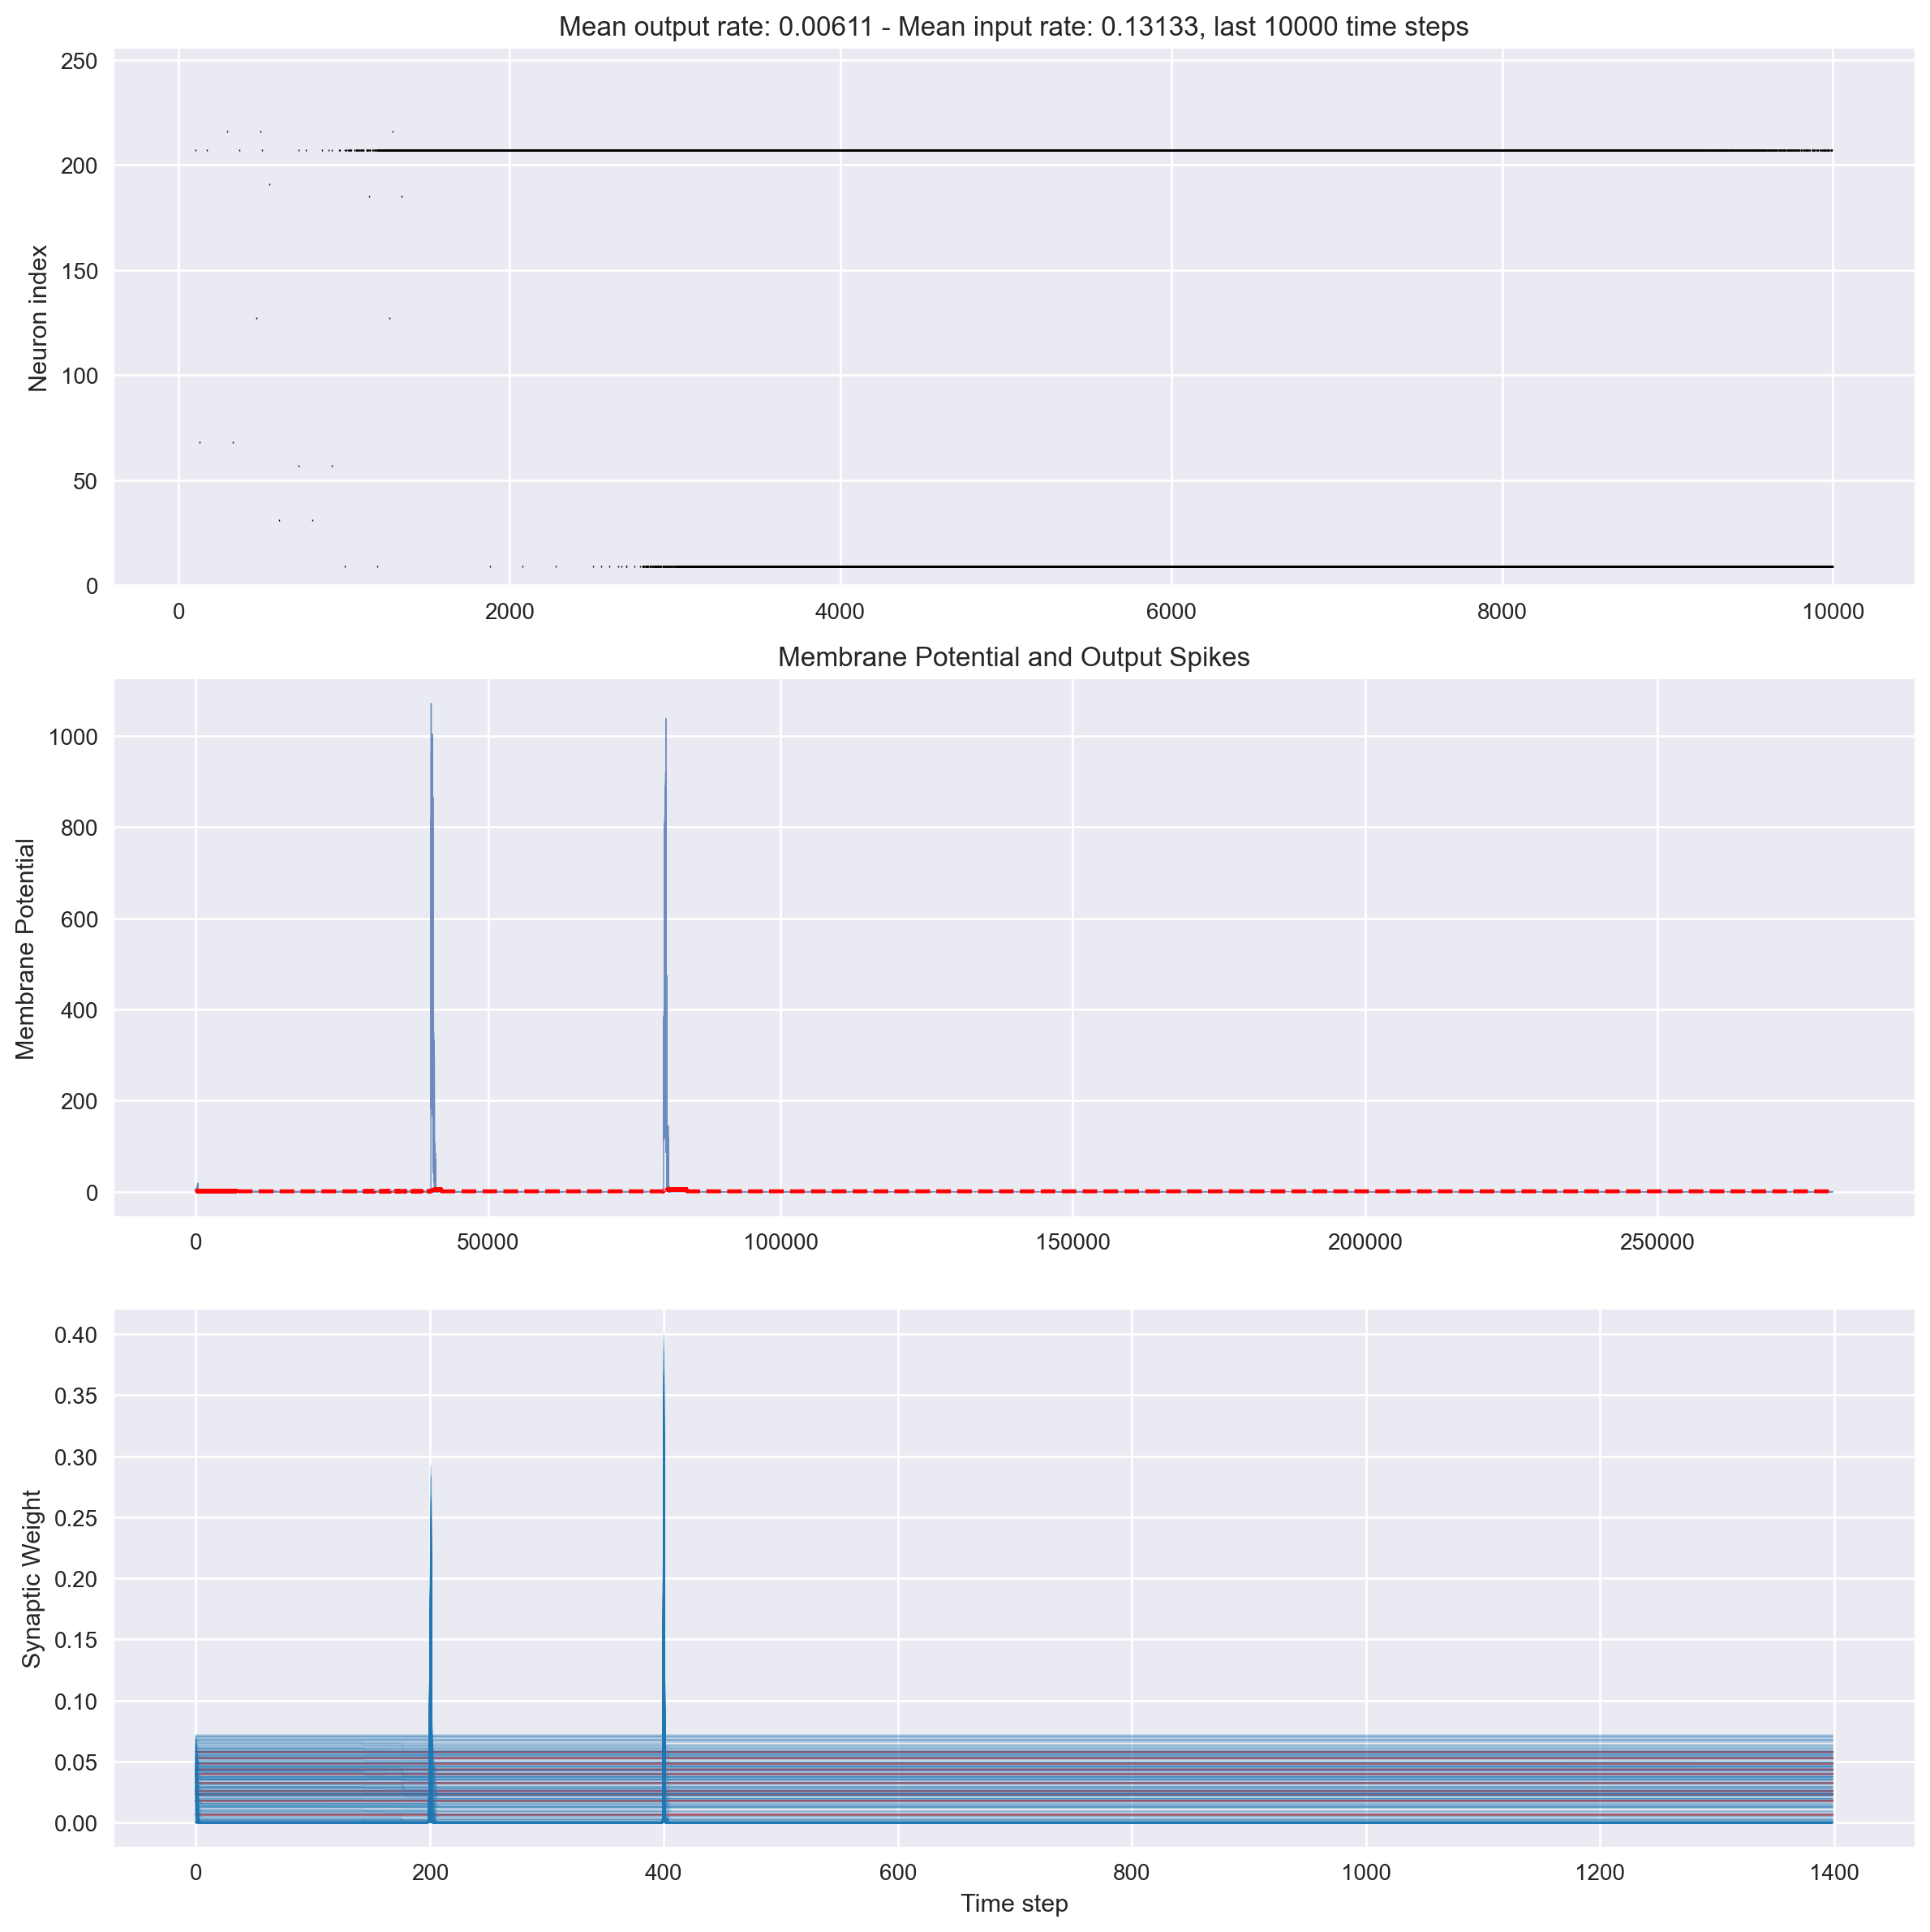

 The total plotting time is 6.47 seconds


In [ ]:
# plot the results
start_time = time.time()
model.plot_simulation(neuron_index=4)
print(f' The total plotting time is {time.time() - start_time:.2f} seconds')

In [ ]:
# display(np.load(r".\random\AeAi.npy").shape)
# display(np.load(r".\random\AiAe.npy").shape)
# display(np.load(r".\random\XeAe.npy").shape)
# display(np.load(r".\random\XeAi.npy").shape)
# display(np.load(r".\weights\theta_A.npy").shape)
# display(np.load(r".\weights\XeAe.npy").shape)
# display(np.load(r".\random\XeAe.npy")[:,2].reshape(400,784).min()) # this is the real matrix of weights
# display(np.load(r".\random\XeAe.npy")[:,2].reshape(400,784).max())

